In [1]:
import os
import sys
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import softmax
from sklearn.metrics import f1_score
from hyperopt import fmin, tpe, hp, Trials


PROJECT_DIR="/mnt/workspace/__ing/cving/chest-xray-diagnosis-and-report"
sys.path.append(PROJECT_DIR)
cache_dir = os.path.join(
    PROJECT_DIR,
    "hf_cache"
)


from utils.utils import initialize_env_variables, word_counter, count_ab_categories
from utils.huggingface import load_model_and_processor, vectorize_image, convert_text_to_diagnosis
from utils.multithread import map_progress
initialize_env_variables()


from huggingface_hub import login
login(os.getenv('HF_READING_TOKEN'))

from datasets import load_dataset, load_from_disk, Dataset
import torch

Initialized environment variables listed in: /mnt/workspace/__ing/cving/chest-xray-diagnosis-and-report/.env
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/mohammed/.cache/huggingface/token
Login successful


# openai/clip-vit-base-patch32

In [2]:
# model_module_name = "CLIPModel/openai/clip-vit-base-patch32"
# processor_module_name = "CLIPProcessor/openai/clip-vit-base-patch32"


model_module_name = "ViTModel/google/vit-base-patch16-224-in21k"
processor_module_name = "ViTFeatureExtractor/google/vit-base-patch16-224-in21k"

# model_module_name = "ViTModel/google/vit-large-patch32-224-in21k"
# processor_module_name = "ViTFeatureExtractor/google/vit-large-patch32-224-in21k"

model, processor = load_model_and_processor(
    model_module_name=model_module_name,
    processor_module_name=processor_module_name,
    cache_dir=cache_dir,
)

/home/mohammed/anaconda3/envs/vit-env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
seed = 42
sample_size = 100

full_dataset = load_dataset(
    "hongrui/mimic_chest_xray_v_1", cache_dir=cache_dir
)['train'].shuffle(seed=seed).select(range(sample_size))

In [4]:
full_dataset = full_dataset.map(
    function=convert_text_to_diagnosis,
    batched=True
)
full_dataset

Dataset({
    features: ['image', 'text', 'report', 'diagnoses'],
    num_rows: 100
})

In [5]:
vectorized_images = map_progress(
    f=lambda image_dict: vectorize_image(
        model, processor, image_dict
    ),
    seq=full_dataset,
    max_workers=4,
)
vectorized_images = Dataset.from_list(vectorized_images)
vectorized_images

  0%|          | 0/100 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'text', 'report', 'diagnoses', 'image_vectorized'],
    num_rows: 100
})

In [6]:
## We focus on the 2 prominent diagnosis categories
print(count_ab_categories(
    vectorized_images['diagnoses'],
    'Pleural Effusion',
    'Lung Opacity'
))

def label_ab_categories(
    image_batch,
    category_a='Pleural Effusion',
    category_b='Lung Opacity',
):
    labels = []
    
    for diagnoses in image_batch['diagnoses']:
        
        if category_a in diagnoses and category_b in diagnoses:
            labels.append(f"{category_a} & {category_b}")
        elif category_a in diagnoses:
            labels.append(f"{category_a}")
        elif category_b in diagnoses:
            labels.append(f"{category_b}")
        else:
            labels.append("Neither")
            
    image_batch['_label'] = labels
            
    return image_batch

{'Pleural Effusion': 23, 'Lung Opacity': 22, 'Pleural Effusion & Lung Opacity': 14, 'Neither': 41}


In [7]:
category_a = 'Pleural Effusion'
category_b = 'No Finding'

In [8]:
vectorized_images = vectorized_images.map(
    function=lambda img: label_ab_categories(
        img, category_a, category_b),
    batched=True
)
vectorized_images

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'text', 'report', 'diagnoses', 'image_vectorized', '_label'],
    num_rows: 100
})

In [14]:
len(vectorized_images[10]['image_vectorized'])

197

In [9]:
from openTSNE import TSNE

seed=42
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
tsne_embeddings = tsne.fit(np.array(vectorized_images['image_vectorized']))

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using exact search using euclidean distance...


ValueError: Found array with dim 3. NearestNeighbors expected <= 2.

In [81]:
ab_labels = {
    f'{category_a}':"r",
    f'{category_b}':"y",
    f"{category_a} & {category_b}":"o",
    'Neither':"b"
}


labels = [ab_labels[label] for label in vectorized_images['_label']]

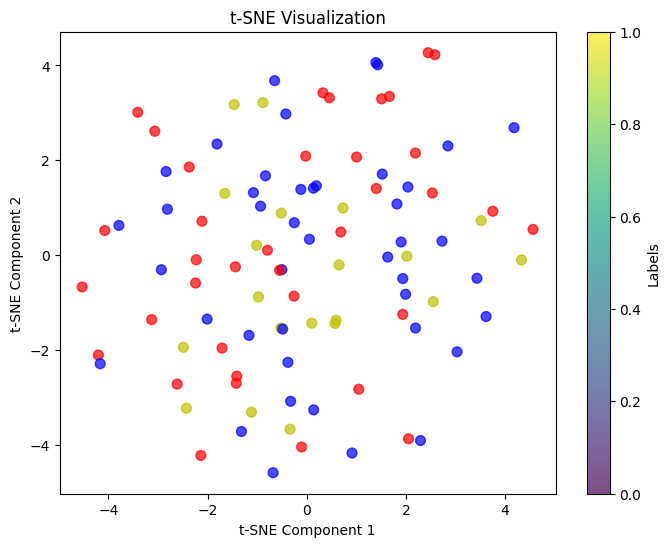

In [83]:
import matplotlib.pyplot as plt

# Plot the t-SNE results with color-coded labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels, s=50, alpha=0.7)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add a color bar legend
plt.colorbar(scatter, label='Labels')
plt.show()